<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW3/blob/main/NLP_HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

from gensim.models.word2vec import Word2Vec
import gensim.downloader as gensim_api

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM, GRU, Dense, Input, Embedding, Dropout
from keras.layers import Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K
from keras.optimizer_v2.adam import Adam

# Dataset

In [2]:
!gdown 11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
!gdown 1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
!gdown 127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU

Downloading...
From: https://drive.google.com/uc?id=11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
To: /content/dev.conll
100% 478k/478k [00:00<00:00, 40.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
To: /content/test.conll
100% 677k/677k [00:00<00:00, 96.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU
To: /content/train.conll
100% 11.4M/11.4M [00:00<00:00, 80.1MB/s]


In [3]:
def dependency_create(row):
  dependency_index = row["DependencyIndex"]
  index = row["Index"]

  if dependency_index == 0:
    return "Root"
  else:
    different = dependency_index - index

    if different > 0:
      return f"{different}R"
    elif different < 0:
      return f"{abs(different)}L"
    else:
      raise Exception(row)

In [4]:
def load_and_preprocess_dataset(path):
  dataset = pd.read_csv(path, delimiter="\t", header=None, names=["Index", "Word", "DependencyIndex"])
  dataset = dataset.dropna()
  dataset["Index"] = dataset["Index"].astype(int)
  dataset["DependencyIndex"] = dataset["DependencyIndex"].astype(int)
  dataset["Dependency"] = dataset.apply(dependency_create, axis=1)

  return dataset

In [5]:
train_dataset = load_and_preprocess_dataset("/content/train.conll")
valid_dataset = load_and_preprocess_dataset("/content/dev.conll")
test_dataset = load_and_preprocess_dataset("/content/test.conll")

In [6]:
label_dictionary = {"PAD": 0}

for i, label in enumerate(set(train_dataset["Dependency"].values.tolist() +
                              valid_dataset["Dependency"].values.tolist() +
                              test_dataset["Dependency"].values.tolist())):
  label_dictionary[label] = i+1

In [7]:
number_labels = len(label_dictionary)

In [8]:
max_number_sequence = max(max(train_dataset["Index"].values), max(valid_dataset["Index"].values), max(test_dataset["Index"].values))

# Embedding

In [9]:
print(gensim_api.load("word2vec-google-news-300", return_path=True))
print(gensim_api.load("glove-wiki-gigaword-300", return_path=True))

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
/root/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz


In [10]:
word2vec_model = gensim_api.load("word2vec-google-news-300")
glove_model = gensim_api.load("glove-wiki-gigaword-300")

# Sequence Dataset

In [11]:
def convert_to_sequence(dataset):
  sequenced_dataset = []

  for i, item in dataset.iterrows():
    if item["Index"] == 1:
      if i>0:
        sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
      new_words = [item["Word"]]
      new_labels = [item["Dependency"]]
    else:
      new_words.append(item["Word"])
      new_labels.append(item["Dependency"])
  
  sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
  return pd.DataFrame(sequenced_dataset)

In [12]:
train_dataset = convert_to_sequence(train_dataset)
valid_dataset = convert_to_sequence(valid_dataset)
test_dataset = convert_to_sequence(test_dataset)

In [13]:
def create_apply_embedding(embedding_model):
  def apply_embedding(row):
    vectors = []
    for word in row["Words"]:
      try:
        vector = embedding_model.get_vector(word)
      except KeyError:
        vector = np.zeros(300)
      vectors.append(vector)

    for i in range(141-len(row["Words"])):
      vectors.append(np.zeros(300))

    return np.stack(vectors)

  return apply_embedding

In [14]:
def apply_label_index(row):
  labels = []
  for label in row["Labels"]:
    labels.append(label_dictionary[label])

  for i in range(max_number_sequence-len(row["Labels"])):
    labels.append(label_dictionary["PAD"])
  
  return np.stack(labels)

In [15]:
class DatasetGenerator(keras.utils.Sequence):
  def __init__(self, dataset, batch_size, embedding_model):
    self.dataset = dataset
    self.batch_size = batch_size
    self.apply_embedding = create_apply_embedding(embedding_model)

  def __len__(self):
    return math.ceil(len(self.dataset)/self.batch_size)
  
  def __getitem__(self, idx):
    batch_vectors = np.stack(self.dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(self.apply_embedding, axis=1).values)
    batch_labelindex = np.stack(self.dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(apply_label_index, axis=1).values)

    return batch_vectors, batch_labelindex

# BiRNN Model

In [16]:
class BiRNN(keras.Model):
  def __init__(self, number_cells, rnn_cell=LSTM, number_rnn_layers=1, number_hidden_fc_layers=0, dropout_rate=0):
    super().__init__()

    self.model = Sequential([])
    self.model.add(Input((max_number_sequence, 300)))

    for _ in range(number_rnn_layers):
      self.model.add(Bidirectional(rnn_cell(number_cells, return_sequences=True)))

    for _ in range(number_hidden_fc_layers):
      self.model.add(Dense(number_cells))

    self.model.add(Dropout(dropout_rate))
    self.model.add(TimeDistributed(Dense(number_labels, activation="softmax")))
  
  def call(self, inputs):
    return self.model(inputs)

In [17]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = K.argmax(y_pred, axis=-1)
    y_true_class = K.argmax(y_true, axis=-1)
    y_true_class = K.cast(y_true, "int64")

    ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

# Model Selection

In [21]:
for embedding_name, embedding_model in [("word2vec", word2vec_model),
                                        ("glove",glove_model)]:
  
  train_dataset_generator = DatasetGenerator(dataset=train_dataset, batch_size=32, embedding_model=word2vec_model)
  valid_dataset_generator = DatasetGenerator(dataset=valid_dataset, batch_size=32, embedding_model=word2vec_model)
  test_dataset_generator = DatasetGenerator(dataset=test_dataset, batch_size=32, embedding_model=word2vec_model)

  for rnn_cell in [LSTM, GRU]:
    for number_rnn_layers, number_hidden_fc_layers, dropout_rate in [(1, 0, 0), (2, 2, 0.5)]:
        print(f"Embedding = {embedding_name} | Cell = {rnn_cell} | #RNN Layers = {number_rnn_layers} | #Hidden FC Layers = {number_hidden_fc_layers} | Dropout Rate = {dropout_rate}")

        model = BiRNN(number_cells=32, rnn_cell=rnn_cell,
                      number_rnn_layers=number_rnn_layers,
                      number_hidden_fc_layers=number_hidden_fc_layers,
                      dropout_rate=0)
        
        model.compile(optimizer=Adam(0.01),
                      loss="sparse_categorical_crossentropy",
                      metrics=["Accuracy", ignore_class_accuracy(0)])
        
        es_callback = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

        history = model.fit(x=train_dataset_generator,
                epochs=20, callbacks=[es_callback],
                validation_data=valid_dataset_generator, verbose=0)
        
        print(f"Train Real Accuracy = {round(model.evaluate(train_dataset_generator, verbose=0)[2]*100, 2)}", end=" | ")
        print(f"Valid Real Accuracy = {round(model.evaluate(valid_dataset_generator, verbose=0)[2]*100, 2)}", end=" | ")
        print(f"Test Real Accuracy = {round(model.evaluate(test_dataset_generator, verbose=0)[2]*100, 2)}")
        

Embedding = word2vec | Cell = <class 'keras.layers.recurrent_v2.LSTM'> | #RNN Layers = 1 | #Hidden FC Layers = 0 | Dropout Rate = 0
Train Real Accuracy = 80.62 | Valid Real Accuracy = 76.58 | Test Real Accuracy = 77.16
Embedding = word2vec | Cell = <class 'keras.layers.recurrent_v2.LSTM'> | #RNN Layers = 2 | #Hidden FC Layers = 2 | Dropout Rate = 0.5
Train Real Accuracy = 86.6 | Valid Real Accuracy = 82.05 | Test Real Accuracy = 82.67
Embedding = word2vec | Cell = <class 'keras.layers.recurrent_v2.GRU'> | #RNN Layers = 1 | #Hidden FC Layers = 0 | Dropout Rate = 0
Train Real Accuracy = 76.84 | Valid Real Accuracy = 74.74 | Test Real Accuracy = 75.05
Embedding = word2vec | Cell = <class 'keras.layers.recurrent_v2.GRU'> | #RNN Layers = 2 | #Hidden FC Layers = 2 | Dropout Rate = 0.5
Train Real Accuracy = 78.26 | Valid Real Accuracy = 76.41 | Test Real Accuracy = 76.6
Embedding = glove | Cell = <class 'keras.layers.recurrent_v2.LSTM'> | #RNN Layers = 1 | #Hidden FC Layers = 0 | Dropout Rate

# Evaluation

In [28]:
model.evaluate(train_dataset_generator)
model.evaluate(valid_dataset_generator)
model.evaluate(test_dataset_generator)

76/76 [==============================] - 2s 32ms/step - loss: 0.1433 - Accuracy: 0.9597 - ignore_accuracy: 0.7629


[0.14327597618103027, 0.9597071409225464, 0.762917697429657]

In [82]:
test_predict = model.predict(test_dataset_generator)
test_predict = K.argmax(test_predict).numpy()
test_predict = test_predict.ravel()

In [85]:
test_true = []
for i in range(len(test_dataset_generator)):
  for row in test_dataset_generator.__getitem__(i)[1]:
    test_true.append(row)
test_true = np.stack(test_true).squeeze()
test_true = test_true.ravel()

In [101]:
precision_score(test_true, test_predict)

ValueError: ignored

0.758732622962388

In [87]:
matrix = confusion_matrix(test_true, test_predict)

In [108]:
accuracy = accuracy_score(test_true, test_predict, sample_weight=np.array([(0 if item else 1) for item in test_true==0]))

number_data = []
for i in range(len(matrix)):
  number_data.append(matrix[i])

precisions = []
recalls = []
for i in range(len(matrix)):
  precisions.append(matrix[i,i]/sum(matrix[:,i]))
  recalls.append(matrix[i,i]/sum(matrix[i]))

print(precisions)

precision = np.average(precisions[1:])
recall = np.average(recalls[1:])

print(accuracy, precision, recall)

[0.998958545904904, 0.9145704793545325, nan, nan, 0.5384615384615384, nan, nan, 0.125, nan, 0.16666666666666666, nan, 0.0, nan, nan, 0.7133160956690369, nan, nan, 0.0, nan, nan, 0.07692307692307693, 0.3333333333333333, 0.5777126099706745, 0.0, nan, nan, 0.7025977178926924, 0.38686131386861317, nan, 0.23383084577114427, 0.0, 0.25, nan, nan, 0.7031082529474812, 0.5314009661835749, nan, 0.48475120385232745, 0.14545454545454545, 0.3333333333333333, 0.09615384615384616, 0.0, nan, 0.020833333333333332, 0.35, 0.8391284191006027, nan, 0.5533769063180828, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.42071197411003236, nan, 0.05783132530120482, 0.1, nan, 0.0, nan, 0.2, 0.22033898305084745, 0.0, nan, nan, 0.0, nan, nan, nan, nan, 0.7766803179956637, 0.3814102564102564, 0.43636363636363634, 0.0, nan, 0.6414613423959218, 0.6074074074074074, 0.11570247933884298, nan, 0.12781954887218044, nan, nan, 0.0, 0.7694645779752163, 0.5743944636678201, nan, nan, 0.44086021505376344, 0.06666666666666667, nan, nan,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [104]:
i=1


0.9366873253129178


In [90]:
number_labels

159

In [89]:
number_true = 0
number_all = 0
for i in range(number_labels):
  number_true += matrix[i,i]
number_all = np.sum(matrix) - matrix[0,0]

IndexError: ignored

In [88]:
matrix[0]

array([283922,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      7,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,     11,      0,      0,      0,      0,      0,
            0,      0,      0,      1,      0,      0,      0,      0,
            0,      0,      0,      0,      1,      0,      0,      7,
            0,      0,      0,      0,      0,      0,      0,      0,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      6,      1,      1,      0,      0,      6,      0,
            0,      0,      0,      0,      0,      0,      0,      8,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0])

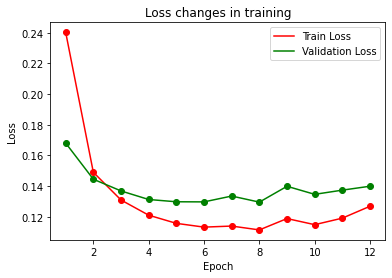

In [30]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.scatter(range(1, len(train_loss)+1), train_loss, color="red")
plt.scatter(range(1, len(train_loss)+1), valid_loss, color="green")

plt.plot(range(1, len(train_loss)+1), train_loss, color="red", label="Train Loss")
plt.plot(range(1, len(train_loss)+1), valid_loss, color="green", label="Validation Loss")

plt.legend()
plt.title("Loss changes in training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()